In [1]:
# get 30 ICs 
import nipype.interfaces.io as nio
import os
PD_ICA_file='/templateflow/PD_ICAs';
ICs_list=list(range(30))
ICs_list=["{:0>4d}".format(x) for x in ICs_list]
# file import
ds_ic = nio.DataGrabber(infields=['IC_id'])
ds_ic.inputs.base_directory = PD_ICA_file # database
ds_ic.inputs.template = 'melodic_IC_%4s.nii.gz' # from cwd
ds_ic.inputs.sort_filelist = True
ds_ic.inputs.IC_id = ICs_list
res_ic = ds_ic.run()
ic_list=res_ic.outputs.outfiles
#print(t1_list)
# read study groups 
#PD_LIST='/codes/PD_template_subjects.list';
GROUPS=['PD','ET','NC']
OUT_DIR='/output/PD_ICA/'
SUB_LIST=[]; AGE_LIST=[]; JCOB_LIST=[];

for group_name in GROUPS:
    current_group=group_name
    current_sub_list_file = '/codes/devel/PD_Marker/'+current_group+'_info_ICA.list'
    # create dir for output
    current_OUT_DIR=OUT_DIR+current_group+'/'
    if not os.path.exists(current_OUT_DIR):
        os.makedirs(current_OUT_DIR)
    #read sub list
    with open(current_sub_list_file, 'r') as f_sub:
        sub_list_raw= f_sub.readlines()
    sub_list = [x[0:-1].split('\t')[0] for x in sub_list_raw] # remove 
    age_list = [int(x[0:-1].split('\t')[1]) for x in sub_list_raw]
    SUB_LIST.append(sub_list);  AGE_LIST.append(age_list);
    N_sub=len(sub_list)
    print(group_name, ': ', N_sub, sub_list, age_list)
    # grab group Jacobians
    ds_jacobian = nio.DataGrabber(infields=['sub_id'])
    ds_jacobian.inputs.base_directory = current_OUT_DIR # database
    ds_jacobian.inputs.template = '%s_desc-preproc_T1w_space-MNI2009c_Warp_Jacobian.nii.gz' # from cwd
    ds_jacobian.inputs.sort_filelist = True
    ds_jacobian.inputs.sub_id = sub_list
    res_jacobian = ds_jacobian.run()
    jacobian_list=res_jacobian.outputs.outfiles
    JCOB_LIST.append(jacobian_list)
pd_sub_list = SUB_LIST[0]; et_sub_list = SUB_LIST[1]; nc_sub_list = SUB_LIST[2]; 
pd_age_list = AGE_LIST[0]; et_age_list = AGE_LIST[1]; nc_age_list = AGE_LIST[2];
pd_jaco_list=JCOB_LIST[0]; et_jaco_list=JCOB_LIST[1]; nc_jaco_list=JCOB_LIST[2];

PD :  46 ['sub-0002', 'sub-0004', 'sub-0005', 'sub-0006', 'sub-0008', 'sub-0009', 'sub-0012', 'sub-0014', 'sub-0015', 'sub-0021', 'sub-0022', 'sub-0023', 'sub-0024', 'sub-0025', 'sub-0028', 'sub-0030', 'sub-0031', 'sub-0034', 'sub-0035', 'sub-0037', 'sub-0038', 'sub-0040', 'sub-0047', 'sub-0051', 'sub-0052', 'sub-0068', 'sub-0075', 'sub-0076', 'sub-0087', 'sub-0094', 'sub-0096', 'sub-0098', 'sub-0103', 'sub-0109', 'sub-0111', 'sub-0118', 'sub-0125', 'sub-0126', 'sub-0129', 'sub-0131', 'sub-0132', 'sub-0133', 'sub-0136', 'sub-1000', 'sub-1020', 'sub-4100'] [70, 76, 45, 63, 59, 57, 47, 66, 65, 53, 62, 50, 63, 44, 61, 72, 51, 70, 69, 68, 54, 63, 75, 54, 56, 66, 66, 48, 57, 66, 73, 57, 62, 69, 69, 54, 60, 57, 69, 80, 74, 68, 62, 77, 66, 56]
ET :  30 ['sub-0016', 'sub-0061', 'sub-0081', 'sub-0115', 'sub-0119', 'sub-0122', 'sub-0134', 'sub-0178', 'sub-1012', 'sub-1120', 'sub-1160', 'sub-1230', 'sub-1310', 'sub-1340', 'sub-1450', 'sub-1500', 'sub-1690', 'sub-1890', 'sub-1920', 'sub-2400', 'su

In [ ]:
# plot group age distribution
import matplotlib.pyplot as plt
import numpy as np
N_BINs=20; X_LIM=[25, 90]; Y_LIM=[0, 8];
#print(AGE_LIST)
fig, ax = plt.subplots(1,3, figsize=[9, 3])
ax[0].hist(AGE_LIST[0], bins=N_BINs)
ax[0].set_ylim(Y_LIM)
ax[0].set_xlim(X_LIM)
ax[0].set_title('PD ('+str(len(AGE_LIST[0]))+') age with '+str(int(np.mean(AGE_LIST[0])))+'~'+str(int(np.std(AGE_LIST[0]))), color='r')

ax[1].hist(AGE_LIST[1], bins=N_BINs)
ax[1].set_ylim(Y_LIM)
ax[1].set_xlim(X_LIM)
ax[1].set_title('ET ('+str(len(AGE_LIST[1]))+') age with '+str(int(np.mean(AGE_LIST[1])))+'~'+str(int(np.std(AGE_LIST[1]))), color='r')

ax[2].hist(AGE_LIST[2], bins=N_BINs)
ax[2].set_ylim(Y_LIM)
ax[2].set_xlim(X_LIM)
ax[2].set_title('NC ('+str(len(AGE_LIST[2]))+') age with '+str(int(np.mean(AGE_LIST[2])))+'~'+str(int(np.std(AGE_LIST[2]))), color='r')
fig.subplots_adjust(wspace=0.15, hspace=0)
plt.show()

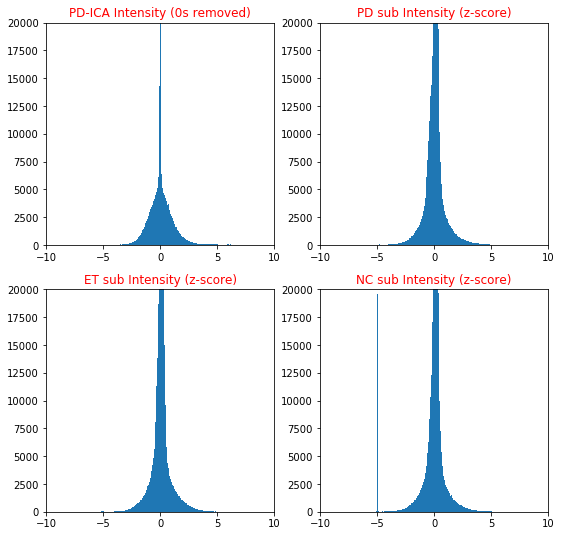

In [91]:
# show PD-ICA pattern
#import pandas as pd
#import matplotlib.pyplot as plt
#from nilearn import plotting
atlas_09_masked='/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_T1w.nii.gz'
tmp_img=nib.load(atlas_09_masked);
def plot_ic_distr(ic_img, pd_img, et_img, nc_img, template):
    import nibabel as nib
    import numpy as np
    from scipy import stats
    import matplotlib.pyplot as plt
    from nilearn.image import resample_to_img
    ic_img_re = resample_to_img(ic_img, template)
    pd_img_re = resample_to_img(pd_img, template)
    et_img_re = resample_to_img(et_img, template)
    nc_img_re = resample_to_img(nc_img, template)
    data  = ic_img_re.get_fdata()
    data1 = pd_img_re.get_fdata()
    data2 = et_img_re.get_fdata()
    data3 = nc_img_re.get_fdata()
    #X = stats.zscore(np.asarray(data))
    nz_pos=np.flatnonzero(data)
    IC_val=list(data.ravel()[nz_pos])
    pd_val=list(stats.zscore(data1.ravel()[nz_pos]))
    et_val=list(stats.zscore(data2.ravel()[nz_pos]))
    nc_val=list(stats.zscore(data3.ravel()[nz_pos]))
    YLIM=[0, 20000]; N_BINs=500; XLIM=[-10,10]
    fig, ax = plt.subplots(2,2, figsize=[9, 9])
    ax[0,0].hist(IC_val, bins=N_BINs)
    ax[0,0].set_ylim(YLIM)
    ax[0,0].set_xlim(XLIM)
    ax[0,0].set_title('PD-ICA Intensity (0s removed)', color='r')

    ax[0,1].hist(pd_val, bins=N_BINs)
    ax[0,1].set_ylim(YLIM)
    ax[0,1].set_xlim(XLIM)
    ax[0,1].set_title('PD sub Intensity (z-score)', color='r')

    ax[1,0].hist(et_val, bins=N_BINs)
    ax[1,0].set_ylim(YLIM)
    ax[1,0].set_xlim(XLIM)
    ax[1,0].set_title('ET sub Intensity (z-score)', color='r')
    
    ax[1,1].hist(nc_val, bins=N_BINs)
    ax[1,1].set_ylim(YLIM)
    ax[1,1].set_xlim(XLIM)
    ax[1,1].set_title('NC sub Intensity (z-score)', color='r')
    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()
#

import nibabel as nib
i_IC=0; i_pd=0; i_et=0; i_nc=0;
plot_ic_distr(nib.load(ic_list[i_IC]), nib.load(pd_jaco_list[i_pd]), \
              nib.load(et_jaco_list[i_et]), nib.load(nc_jaco_list[i_nc]), tmp_img)
## check size
#PD_ICA_img=nib.load(ic_list[1]);
#pd_sub_img=nib.load(pd_jaco_list[0]);
#OUT_DIR='/output/PD_ICA/'
#atlas_09_masked='/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_T1w.nii.gz'
#tmp_img=nib.load(atlas_09_masked);
#print(PD_ICA_img.header)
#print(PD_ICA_img.shape)
#print(pd_sub_img.shape)
#print(tmp_img.shape)

In [2]:
# read all group Jacobian data
#ic_list
#pd_sub_list, et_sub_list, nc_sub_list; 
#pd_age_list, et_age_list, nc_age_list;
#pd_jaco_list, et_jaco_list, nc_jaco_list;
pd_jaco_x_list=[]; et_jaco_x_list=[]; nc_jaco_x_list=[]

import nibabel as nib
PD_ICA_img=nib.load(ic_list[0]);
def grab_groupXICA(ic_img, img_list):
    import nibabel as nib
    from nilearn.image import resample_to_img
    from nilearn.image import math_img
    x_list=[];
    N_sub=len(img_list)
    for i in range(N_sub):
        sub_img=nib.load(img_list[i])
        sub_img_re = resample_to_img(sub_img, ic_img)
        sub_img_x  = math_img("img1 * img2", img1=ic_img, img2=sub_img_re)
        x_list.append(sub_img_x)
    return x_list
pd_jaco_x_list=grab_groupXICA(PD_ICA_img, pd_jaco_list); 
et_jaco_x_list=grab_groupXICA(PD_ICA_img, et_jaco_list); 
nc_jaco_x_list=grab_groupXICA(PD_ICA_img, nc_jaco_list);

In [6]:
import numpy as np
pd_jaco_x_list_mean = [np.mean(x.get_fdata()) for x in pd_jaco_x_list]
et_jaco_x_list_mean = [np.mean(x.get_fdata()) for x in et_jaco_x_list]
nc_jaco_x_list_mean = [np.mean(x.get_fdata()) for x in nc_jaco_x_list]
#pd_age_list, et_age_list, nc_age_list;
#a=np.array(pd_jaco_x_list[0].get_fdata())
print(np.mean(pd_jaco_x_list_mean))
print(np.mean(et_jaco_x_list_mean))
print(np.mean(nc_jaco_x_list_mean))
import statsmodels

0.03680125168047021
0.03572954644173186
0.038807880520973004


In [1]:
grou_names=['PD']*len(pd_jaco_x_list_mean)+['ET']*len(et_jaco_x_list_mean)+['NC']*len(nc_jaco_x_list_mean);
age=pd_age_list+et_age_list+nc_age_list;
group_ica_mean=pd_jaco_x_list_mean+et_jaco_x_list_mean+nc_jaco_x_list_mean;
#print(grou_names)
#print(age)
#print(group_ica_mean)
import pandas as pd
#import seaborn as sns
# load data file
#d = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/twowayanova.txt", sep="\t")
# reshape the d dataframe suitable for statsmodels package 
# you do not need to reshape if your data is already in stacked format. Compare d and d_melt tables for detail 
# understanding 
df_1=pd.DataFrame({'group':grou_names, 'age':age, 'ica_mean': group_ica_mean})

# generate a boxplot to see the data distribution by genotypes and years. Using boxplot, we can easily detect the 
# differences between different groups
#sns.boxplot(x="group", y="age", hue="ica_mean", data=df_1, palette="Set3") 
#df_1.to_csv('data.csv')
print(df_1)


NameError: name 'pd_jaco_x_list_mean' is not defined

In [20]:
import pandas as pd
df_1=pd.read_csv('data.csv')
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Ordinary Least Squares (OLS) model
# C(Genotype):C(years) represent interaction term
model= ols('ica_mean ~ (group) + (age) + (group):(age)', data=df_1).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
model1= ols('ica_mean ~ (group) + (age)', data=df_1).fit()
anova_table1 = sm.stats.anova_lm(model1, typ=3)

In [22]:
print(anova_table)
print(model.conf_int())

print(anova_table1)
print(model1.conf_int())

print(model.aic, model.bic)
print(model1.aic, model1.bic)


             sum_sq     df          F        PR(>F)
Intercept  0.000753    1.0  50.241385  1.687041e-10
group      0.000022    2.0   0.721567  4.884068e-01
age        0.000067    1.0   4.443968  3.742766e-02
group:age  0.000031    2.0   1.020080  3.641449e-01
Residual   0.001560  104.0        NaN           NaN
                        0         1
Intercept        0.036551  0.064947
group[T.NC]     -0.025500  0.006262
group[T.PD]     -0.024180  0.008565
age             -0.000402 -0.000012
group[T.NC]:age -0.000065  0.000397
group[T.PD]:age -0.000125  0.000343
             sum_sq     df           F        PR(>F)
Intercept  0.002890    1.0  192.610707  1.386485e-25
group      0.000042    2.0    1.398921  2.513829e-01
age        0.000077    1.0    5.109888  2.583317e-02
Residual   0.001590  106.0         NaN           NaN
                    0         1
Intercept    0.036392  0.048523
group[T.NC] -0.000754  0.003908
group[T.PD] -0.001847  0.002115
age         -0.000174 -0.000011
-903.846277

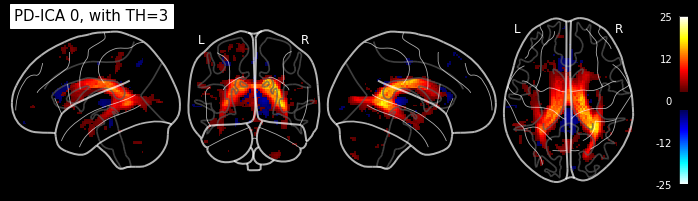

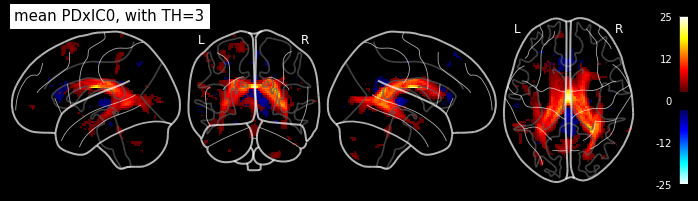

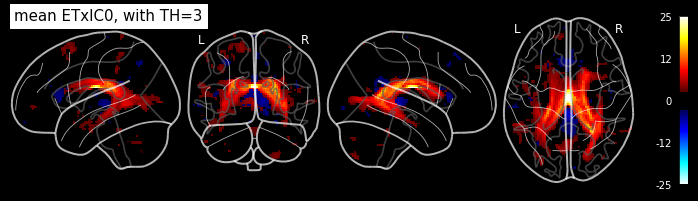

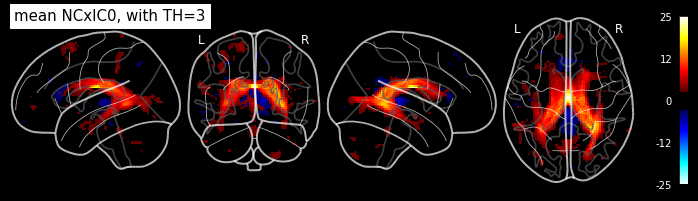

In [112]:
from nilearn import image
from nilearn.image import math_img
from nilearn import plotting
pd4D=image.concat_imgs(pd_jaco_x_list); pd4D_mean = math_img("np.mean(img,axis=3)", img=pd4D)
et4D=image.concat_imgs(et_jaco_x_list); et4D_mean = math_img("np.mean(img,axis=3)", img=et4D)
nc4D=image.concat_imgs(nc_jaco_x_list); nc4D_mean = math_img("np.mean(img,axis=3)", img=nc4D)
#print(pd4D_mean.shape, et4D_mean.shape, nc4D_mean.shape)

TH=3
VMIN= -25; VMAX=25;
plotting.plot_glass_brain(PD_ICA_img, title='PD-ICA '+str(i_IC)+', with TH='+str(TH), display_mode='lyrz',
                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX, threshold=TH)
plotting.plot_glass_brain(pd4D_mean, title='mean PDxIC'+str(i_IC)+', with TH='+str(TH), display_mode='lyrz',
                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX, threshold=TH)
plotting.plot_glass_brain(et4D_mean, title='mean ETxIC'+str(i_IC)+', with TH='+str(TH), display_mode='lyrz',
                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX,threshold=TH)
plotting.plot_glass_brain(nc4D_mean, title='mean NCxIC'+str(i_IC)+', with TH='+str(TH), display_mode='lyrz',
                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX,threshold=TH)

(<nibabel.nifti1.Nifti1Image at 0x7f6f746d3f60>,
 <nibabel.nifti1.Nifti1Image at 0x7f6f77182f60>)

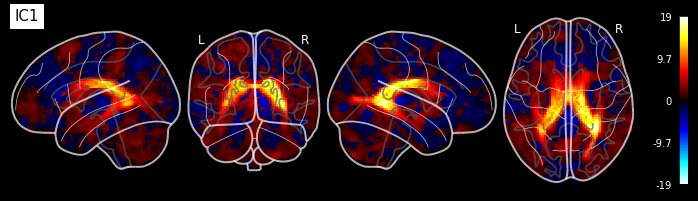

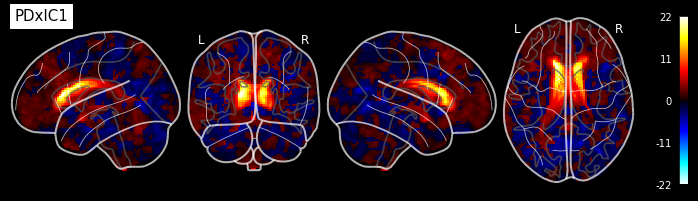

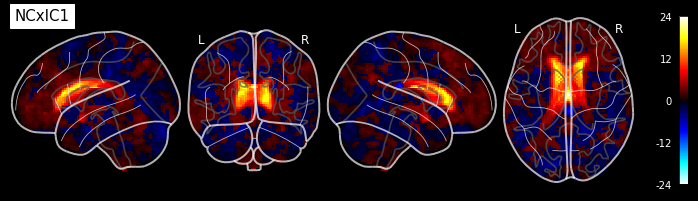

In [86]:
#cross product prediction
#%%time
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.image import resample_to_img
from nilearn.image import math_img

def plt_xIC(ic_img, pd_img, nc_img, TH, i_IC): 
    import numpy as np
    from scipy import stats
    import matplotlib.pyplot as plt
    import nibabel as nib
    from nilearn.image import resample_to_img
    from nilearn import plotting

    resampled_data1_img = resample_to_img(pd_img, ic_img)
    resampled_data2_img = resample_to_img(nc_img, ic_img)
    result_img1 = math_img("img1 * img2", img1=img, img2=resampled_data1_img)
    result_img2 = math_img("img1 * img2", img1=img, img2=resampled_data2_img)
    plotting.plot_glass_brain(ic_img, title='IC'+str(i_IC+1), display_mode='lyrz',
                              black_bg=True, colorbar=True, plot_abs=False,threshold=TH)
    plotting.plot_glass_brain(result_img1, title='PDxIC'+str(i_IC+1), display_mode='lyrz',
                              black_bg=True, colorbar=True, plot_abs=False,threshold=TH)
    plotting.plot_glass_brain(result_img2, title='NCxIC'+str(i_IC+1), display_mode='lyrz',
                              black_bg=True, colorbar=True, plot_abs=False,threshold=TH)
    return result_img1, result_img2
i_IC=0; i_sub=0; TH=0
ic_img = nib.load(ic_list[i_IC]);   
pd_img = nib.load(pd_list[i_sub]); 
nc_img = nib.load(nc_list[i_sub]);
#resampled_data1_img = resample_to_img(pd_img, ic_img)
#resampled_data2_img = resample_to_img(nc_img, ic_img)
plt_xIC(ic_img, pd_img, nc_img, TH, i_IC)

In [72]:
i_IC=0; i_sub=0; TH=0
ic_img = nib.load(ic_list[i_IC]);   
pd_img = nib.load(pd_list[i_sub]); 
nc_img = nib.load(nc_list[i_sub]);
#resampled_data1_img = resample_to_img(pd_img, ic_img)
#resampled_data2_img = resample_to_img(nc_img, ic_img)

def get_imageData(img_str, img_ic):
    import numpy as np
    import nibabel as nib
    from nilearn.image import resample_to_img
    img = nib.load(img_str);
    resampled_img = resample_to_img(img, ic_img)
    data_ic = ic_img.get_fdata()
    data = resampled_img.get_fdata()
    nz_pos=np.flatnonzero(data_ic)
    IC_val=data_ic.ravel()[nz_pos]
    img_val=stats.zscore(data.ravel()[nz_pos])
    return [data, IC_val, img_val]

pd_data = [get_image(x,ic_img) for x in pd_list]
nc_data = [get_image(x,ic_img) for x in nc_list]
print(np.sum(pd_data[0][0]))
print(np.sum(pd_data[1][0]))

1060051.450135765
1059669.8242368363


In [77]:
from scipy import stats
pd_mean=[np.mean(x[0]) for x in pd_data]
nc_mean=[np.mean(x[0]) for x in nc_data]
print(stats.ttest_ind(pd_mean, nc_mean, equal_var=True))
print(stats.ttest_ind(pd_mean, nc_mean, equal_var=False))

Ttest_indResult(statistic=-1.3711034291991173, pvalue=0.17417680771735503)
Ttest_indResult(statistic=-1.206577160233266, pvalue=0.23464457921760362)


In [81]:
i_IC=0; i_sub=0; TH=0
ic_img = nib.load(ic_list[i_IC]);   
pd_img = nib.load(pd_list[i_sub]); 
nc_img = nib.load(nc_list[i_sub]);
def get_xImageData(img_str, img_ic):
    import numpy as np
    import nibabel as nib
    from nilearn.image import resample_to_img
    img = nib.load(img_str);
    resampled_img = resample_to_img(img, ic_img)
    x_img = math_img("img1 * img2", img1=img_ic, img2=resampled_img)
    data_ic = ic_img.get_fdata()
    data = x_img.get_fdata()
    return data
xpd_data = [get_xImageData(x,ic_img) for x in pd_list]
xnc_data = [get_xImageData(x,ic_img) for x in nc_list]

ValueError: operands could not be broadcast together with shapes (101,119,97) (235818,) 

In [84]:
xpd_mean=[np.mean(x) for x in xpd_data]
xnc_mean=[np.mean(x) for x in xnc_data]
print(stats.ttest_ind(xpd_mean, xnc_mean, equal_var=True))
print(stats.ttest_ind(xpd_mean, xnc_mean, equal_var=False))

Ttest_indResult(statistic=-2.611701552984461, pvalue=0.010755738938827877)
Ttest_indResult(statistic=-2.5044536648945304, pvalue=0.015007318082083668)


In [87]:
xpd_var=[np.var(x) for x in xpd_data]
xnc_var=[np.var(x) for x in xnc_data]
print(stats.ttest_ind(xpd_var, xnc_var, equal_var=True))
print(stats.ttest_ind(xpd_var, xnc_var, equal_var=False))

Ttest_indResult(statistic=-1.8994027071264423, pvalue=0.06111577484793034)
Ttest_indResult(statistic=-1.8138974536096693, pvalue=0.07480459323692994)
